# Analyse des données issues des ventes en ligne de l'entreprise 

In [84]:
# importation des librairies 
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

In [2]:
# lecture des fichiers csv 
df_vente = pd.read_csv('ventes.csv')
df_client = pd.read_csv('clients.csv')
df_produit = pd.read_csv('produits.csv')

In [3]:
# exploration des données 

In [4]:
df_vente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337016 entries, 0 to 337015
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     337016 non-null  object
 1   date        337016 non-null  object
 2   session_id  337016 non-null  object
 3   client_id   337016 non-null  object
dtypes: object(4)
memory usage: 10.3+ MB


In [59]:
df_vente

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242
...,...,...,...,...
337011,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454
337012,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268
337013,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137
337014,2_227,2021-10-30 16:50:15.997750,s_112349,c_5


In [5]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [60]:
df_client

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943
...,...,...,...
8618,c_7920,m,1956
8619,c_7403,f,1970
8620,c_5119,m,1974
8621,c_5643,f,1968


In [6]:
df_produit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [65]:
df_produit

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3282,2_23,115.99,2
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1


## Mission n° 1 : Nettoyage des données 

### Valeurs manquantes : 

In [7]:
df_vente.isnull().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

In [8]:
df_client.isnull().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [9]:
df_produit.isnull().sum()

id_prod    0
price      0
categ      0
dtype: int64

### Conclusion : Il n'y a pas de valeurs manquantes dans ces 3 fichiers.

### Duplicates : 

In [28]:
df_vente.duplicated(subset=None).value_counts()

False    336890
True        126
dtype: int64

In [11]:
df_client.duplicated('client_id').value_counts()

False    8623
dtype: int64

In [12]:
df_produit.duplicated('id_prod').value_counts()

False    3287
dtype: int64

In [50]:
# sorting by first name
df_vente.sort_values("date")
 
# making a bool series
bool_series = df_vente["date"].duplicated()
 
# displaying data
df_vente.head()
 
# display data
df_vente[bool_series]
a= df_vente.id_prod == 'T_0'

In [74]:
b =df_produit.id_prod == 'T_0'
df_produit.loc[731]

id_prod    T_0
price     -1.0
categ        0
Name: 731, dtype: object

In [107]:
# Les duplicates de la dataframe df_vente, sont des tests effectués le 2021-03-01, je vais les supprimer 
df_vente.drop(df_vente.index[df_vente['id_prod'] == 'T_0'])

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242
...,...,...,...,...
337011,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454
337012,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268
337013,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137
337014,2_227,2021-10-30 16:50:15.997750,s_112349,c_5


In [82]:
df_vente.duplicated(subset=None).value_counts()

False    336816
dtype: int64

### Outliers

<AxesSubplot:>

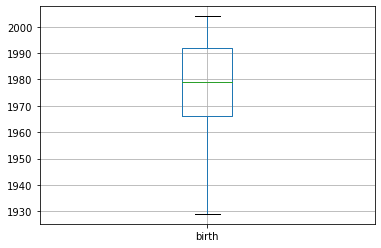

In [86]:
df_client[['birth']].boxplot()

<AxesSubplot:>

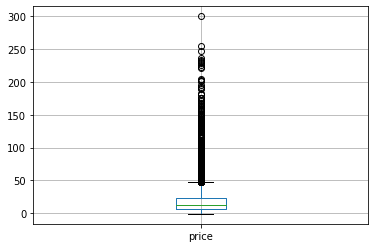

In [87]:
df_produit[['price']].boxplot()

In [106]:
df_produit.loc[df_produit['price'] == 0]

,id_prod,price,categ
0,0_1421,0,0
1,0_1368,0,0
2,0_731,0,0
3,1_587,0,1
4,0_1507,0,0
...,...,...,...
3282,2_23,0,2
3283,0_146,0,0
3284,0_802,0,0
3285,1_140,0,1


In [102]:
df_produit.drop(df_produit.index[df_produit['price'] < 0], inplace = True)

<AxesSubplot:>

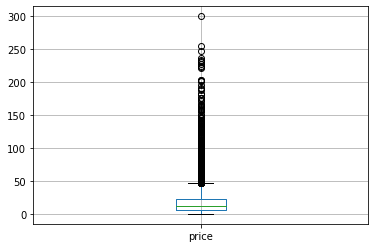

In [103]:
df_produit[['price']].boxplot()

In [96]:
df_client.sex.value_counts()

f    4491
m    4132
Name: sex, dtype: int64

## Mission n° 2 : Analyses des données 

## Mission n° 3 : Corrélations